## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 19: Optimizers, Notebook 3: Comparisons 1

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import hsv_to_rgb

import math
import numpy as np
import seaborn as sbn; sbn.set()

In [2]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


The cells below show different optimizers in action.

In [3]:
# For a given set of x and y values, compute numerical (approximiate) derivatives.
# We use the common convention of xs and ys for the list of x values and y values,
# so we also use ds for the derivates (read xs as "exes", as in many x values)

def make_ds(xs, ys):
    ds = []
    dx = xs[1]-xs[0]
    for i in range(len(xs)):
        if i==0:
            dnew = (ys[1]-ys[0])/dx
        elif i==len(xs)-1:
            dnew = (ys[-1]-ys[-2])/dx
        else:
            dnew = (ys[i+1]-ys[i-1])/(2*dx)
        ds.append(dnew)
    return ds

In [4]:
# get the curve x, y, and derivative at location v

def get_xyd_at_val(v, xs, ys, ds):
    if v <= xs[0]:
        return (xs[0], ys[0], ds[0])
    if v >= xs[-1]:
        return(xs[-1], ys[-1], ds[-1])
    i = 1
    while (v > xs[i]) and (i < len(xs)-1):
        i += 1
    if i >= len(xs)-1:
        return(xs[-1], ys[-1], ds[-1])
    lerp = (v-xs[i-1])/(xs[1]-xs[0])
    x = xs[i] + lerp * (xs[i+1]-xs[i])
    y = ys[i] + lerp * (ys[i+1]-ys[i])
    d = ds[i] + lerp * (ds[i+1]-ds[i])
    return (x, y, d)

In [5]:
# make a bowl-shaped dataset

def make_bowl_data(numpoints=201):
    bowl_scale = 7
    xs = np.linspace(-1, 1, numpoints)
    ys = [10*(1-np.exp(-bowl_scale*x*x)) for x in xs]
    ds = make_ds(xs, ys)
    return (xs, ys, ds)

In [6]:
# make a dataset that's high, flat, then low with nice blends between

def make_up_plateau_down(numpoints=200):
    xs = np.linspace(-1, 1, numpoints)
    ys = np.zeros(len(xs))
    for i in range(len(xs)):
        r = abs(xs[i] - (-1))
        ys[i] += np.exp(-15*r*r)
        r = abs(xs[i] - (.5))
        ys[i] -= np.exp(-15*r*r)
    ys = [y - min(ys) for y in ys]
    ds = make_ds(xs,ys)
    return (xs, ys, ds)

In [7]:
# Make a dataset with a deep minimum and a shallower nearby minimum

def make_overshoot_valley(numpoints=200):
    xs = np.linspace(-1, 1, numpoints)
    ys = np.zeros(len(xs))
    for i in range(len(xs)):
        r = abs(xs[i] - (-.8))
        ys[i] += np.exp(-10*r*r)
        r = abs(xs[i] - (-.3))
        ys[i] -= 3*np.exp(-55*r*r)
        r = abs(xs[i] - .5)
        ys[i] -= np.exp(-3*r*r)
    ys = [y - min(ys) for y in ys]
    ds = make_ds(xs,ys)
    return (xs, ys, ds)

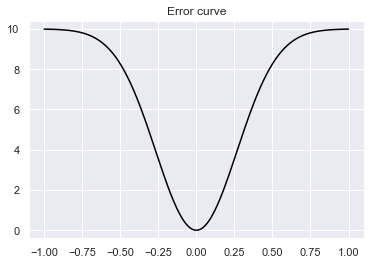

In [8]:
# Show the bowl-shaped error curve

(xs, ys, ds) = make_bowl_data()
plt.plot(xs, ys, color='black')
plt.ylim(-0.4, 10.4)
#plt.yticks([0, 2, 4, 6, 8, 10], [0, .2, .4, .6, .8, 1.0])
plt.title("Error curve")
file_helper.save_figure('just-error-curve')
plt.show()

In [9]:
# Not all that useful with matplotlib because of its crazy scaling, so unless the
# plot is square and uses equal axes in X and Y the arrows won't look right. Sigh.
# But if everything is just-so it's okay. I just dont' want to wrestle with 
# matplotlib any more on this!

def draw_arrow(x0, x1, y0, y1, head_len):
    def set_length(vec, length):
        scl = math.sqrt((vec[0]**2) + (vec[1]**2))
        f = length/scl
        v = [vec[0]*f, vec[1]*f]
        return v
    if (x0 == x1) or (y0 == y1):
        return
    tangent = set_length([x1-x0, y1-y0], -1.0)
    norm = set_length([-tangent[1], tangent[0]], 0.7)
    v = set_length([tangent[0]+norm[0], tangent[1]+norm[1]], head_len)
    plt.plot([x1, x1+v[0]], [y1, y1+v[1]], lw=1, color='green')
    v = set_length([tangent[0]-norm[0], tangent[1]-norm[1]], head_len)
    plt.plot([x1, x1+v[0]], [y1, y1+v[1]], lw=1, color='green')
    plt.plot([x0, x1], [y0, y1], lw=1, color='green')

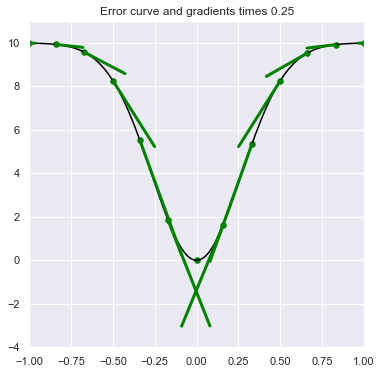

In [10]:
# Show the bowl data, and scaled (and one-sided) derivatives

(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(6,6))
plt.plot(xs, ys, color='black')
plt.plot([0,0], [0,0], lw=1, color='black')
gscl = .25
for fi in np.linspace(0, len(ds)-1, 13):
    i = int(fi)
    theta = math.atan2(ds[i], 1)
    dx = ds[i] * math.cos(theta)
    dy = ds[i] * math.sin(theta)
    plt.plot([xs[i], xs[i]-(gscl*dx)], [ys[i], ys[i]-(gscl*dy)], lw=3, color='green')
    plt.scatter([xs[i]],[ys[i]], color='green', s=30)
plt.title('Error curve and gradients times '+str(gscl))
plt.xlim(-1, 1)
plt.ylim(-4, 11)
#plt.yticks([-4, -2, 0, 2, 4, 6, 8, 10], [-.4, -.2, 0, .2, .4, .6, .8, 1.0])
file_helper.save_figure('error-curve-and-gradients-'+str(gscl))
plt.show()

In [11]:
# Utility function to plot different optimization methods over a set of data.

def plot_learning(xs, ys, ds, start_x, num_pts, start_eta, eta_falloff, momentum=False, gamma=0, nesterov=False):
    np.random.seed(42)
    plt.plot(xs, ys, color='#aaaaaa', zorder=10)
    v = start_x
    ymin = -0.2
    ymax = 1.2
    c = hsv_to_rgb([np.random.uniform(0,1), np.random.uniform(0.8,1), np.random.uniform(0.25,0.75)])
    x, y, d = get_xyd_at_val(start_x, xs, ys, ds)
    plt.scatter([x], [y], s=130, color=c, zorder=30)
    eta = start_eta
    last_vx = 0
    last_vy = 0
    errors = [y]
    
    for i in range(num_pts-1):
        color_scale = 1-((i+1)/(num_pts-1))
        c = np.random.uniform(.2, .8, size=3)
        c = hsv_to_rgb([np.random.uniform(0,1), .8, np.random.uniform(0.5,0.75)])

        x, y, d = get_xyd_at_val(v, xs, ys, ds)
        errors.append(y)
        sign_d = np.sign(d)
        if nesterov:
            (predict_x, predict_y, predict_d) = get_xyd_at_val(x - last_vx, xs, ys, ds)
            d = predict_d
            sign_d = np.sign(d)
        
        theta = math.atan2(d, 1)
        vx = d * math.cos(theta)
        vy = d * math.sin(theta)
        vx *= eta
        vy *= eta

        if momentum or nesterov:
            gvx = gamma * last_vx
            gvy = gamma * last_vy 
            plt.plot([x, x-vx, x-vx-gvx], [y, y-vy, y-vy-gvy], color=c, zorder=20)
            vx = vx+gvx
            vy = vy+gvy
        else:
            plt.plot([x, x-vx], [y, y-vy], color=c, zorder=20)
        
        last_vx = vx
        last_vy = vy
        newx = x-vx
        xx, newy, dd = get_xyd_at_val(newx, xs, ys, ds)
        plt.plot([newx, newx], [y-vy, newy], color='#aaaaaa', zorder=10)
        plt.scatter([x-vx], [newy], s=130, color=c, zorder=30)
        ymin = min(ymin, newy)
        ymax = max(ymax, newy)
        v = newx
        eta *= eta_falloff
        
    plt.xlim(-1,1)
    plt.xticks([],[])
    plt.yticks([],[])
    return errors

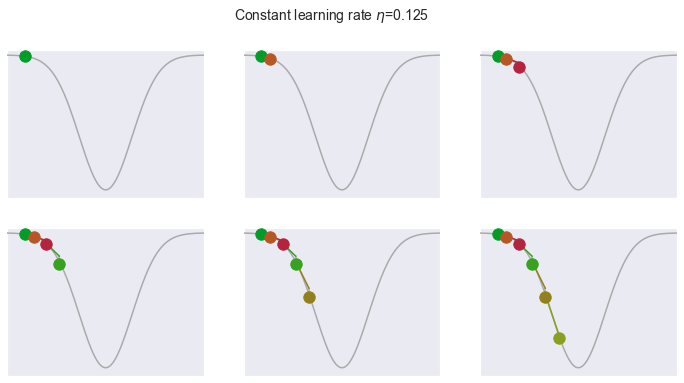

In [12]:
# Show the bowl data with a constant learning rate

(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
start_eta=0.125
for y in range(2):
    for x in range(3):
        plt.subplot(2, 3, 1+x+(y*3))
        plot_learning(xs, ys, ds, -0.83, num_pts=1+x+(y*3), start_eta=start_eta, eta_falloff=1)
        plt.ylim(-0.6, 10.4)
plt.suptitle("Constant learning rate $\eta$="+str(start_eta), fontsize=14)
file_helper.save_figure("constant-learning-rate-grid")
plt.show()

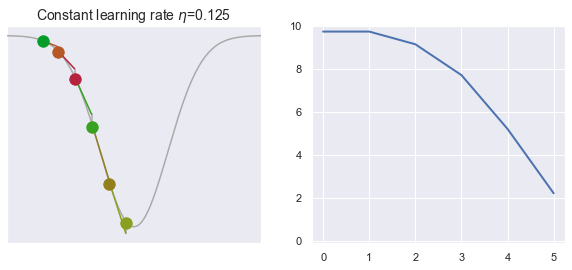

In [13]:
# Show the bowl data with a constant learning rate

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
start_eta=0.125
errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=start_eta, eta_falloff=1)
plt.title("Constant learning rate $\eta$="+str(start_eta), fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("constant-learning-rate")
plt.show()

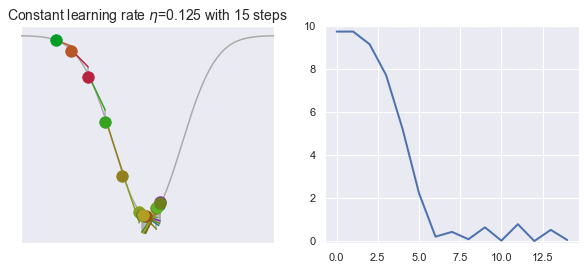

In [14]:
# Show the bowl data with a constant learning rate and more steps than last time

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
start_eta=0.125
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=start_eta, eta_falloff=1)
plt.title("Constant learning rate $\eta$="+str(start_eta)+" with 15 steps", fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("constant-learning-rate-15-steps")
plt.show()

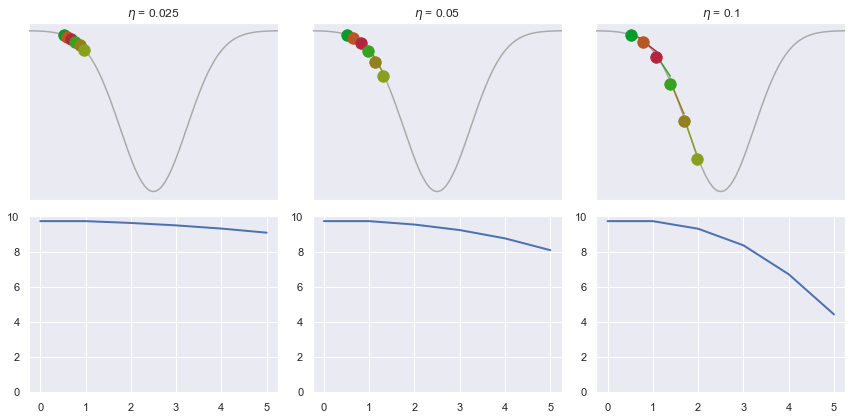

In [15]:
# Show the bowl data with 3 different constant (but smallish) learning rates

(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
etas = [ .025, .05, .1]
for p in range(3):
    plt.subplot(2, 3, 1+p)
    errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=etas[p], eta_falloff=1)
    plt.title("$\eta$ = "+str(etas[p]))
    plt.subplot(2, 3, 4+p)
    plt.plot(range(len(errors)), errors, lw=2)
    plt.ylim(-0.1, 10)
plt.tight_layout()
file_helper.save_figure('different-constant-small-etas-6')
plt.show()

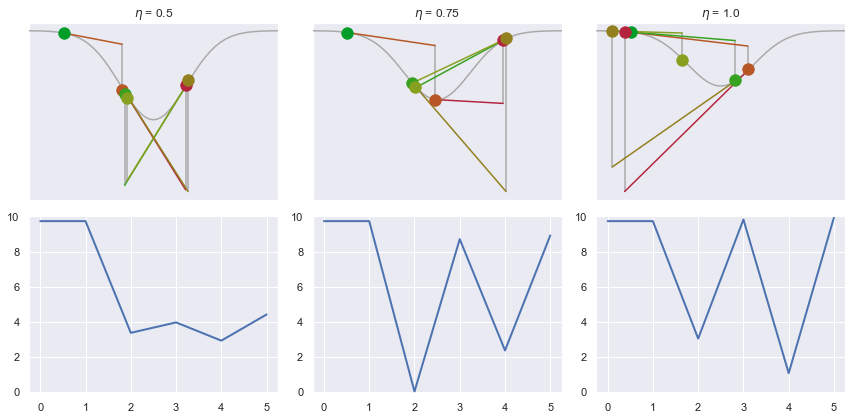

In [16]:
# Show the bowl data with 3 different constant (but largish) learning rates

(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
etas = [ .5, .75, 1.0]
for p in range(3):
    plt.subplot(2, 3, 1+p)
    errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=etas[p], eta_falloff=1)
    plt.title("$\eta$ = "+str(etas[p]))
    plt.subplot(2, 3, 4+p)
    plt.plot(range(len(errors)), errors, lw=2)
    plt.ylim(-0.1, 10)
plt.tight_layout()
file_helper.save_figure('different-constant-large-etas-6')
plt.show()

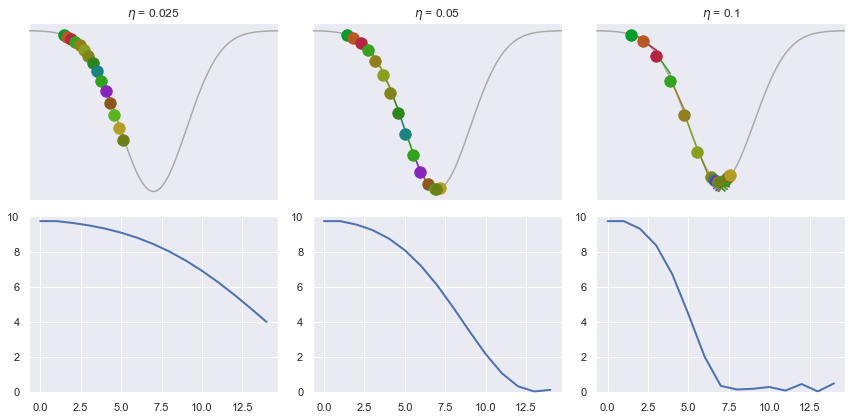

In [17]:
# Show the bowl data with 3 different constant (smallish) learning rates, but more steps than earlier

(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
etas = [ .025, .05, .1]
for p in range(3):
    plt.subplot(2, 3, 1+p)
    errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=etas[p], eta_falloff=1)
    plt.title("$\eta$ = "+str(etas[p]))
    plt.subplot(2, 3, 4+p)
    plt.plot(range(len(errors)), errors, lw=2)
    plt.ylim(-0.1, 10)
plt.tight_layout()
file_helper.save_figure('different-constant-small-etas-15')
plt.show()

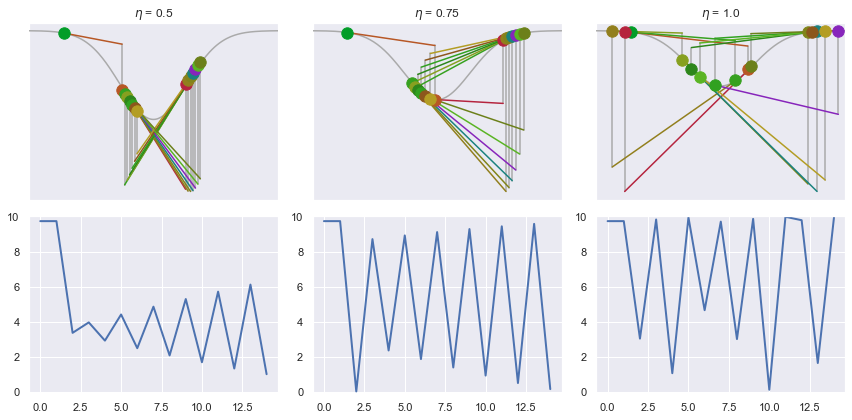

In [18]:
# Show the bowl data with 3 different constant (largish) learning rates, but more steps than earlier

(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
etas = [ .5, .75, 1.0 ]
for p in range(3):
    plt.subplot(2, 3, 1+p)
    errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=etas[p], eta_falloff=1)
    plt.title("$\eta$ = "+str(etas[p]))
    plt.subplot(2, 3, 4+p)
    plt.plot(range(len(errors)), errors, lw=2)
    plt.ylim(-0.1, 10)
plt.tight_layout()
file_helper.save_figure('different-constant-large-etas-15')
plt.show()

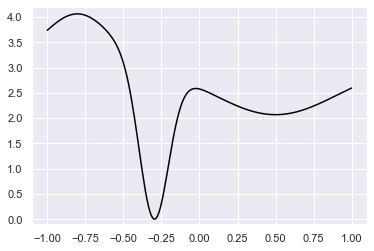

In [19]:
# Show the dataset with one deep minimum, and a shallower, nearby local minimum

(xs, ys, ds) = make_overshoot_valley()
plt.plot(xs, ys, color='black')
plt.ylim(-0.1, 4.2)
file_helper.save_figure("overshoot-demo-curve")
plt.show()

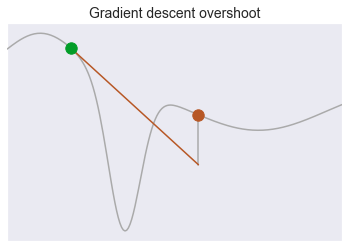

In [20]:
# Show how we might overshoot the deep minimum

(xs, ys, ds) = make_overshoot_valley()
plot_learning(xs, ys, ds, -0.63, num_pts=2, start_eta=0.8, eta_falloff=1)
plt.title("Gradient descent overshoot", fontsize=14)
file_helper.save_figure("gradient-descent-overshoot")
plt.show()

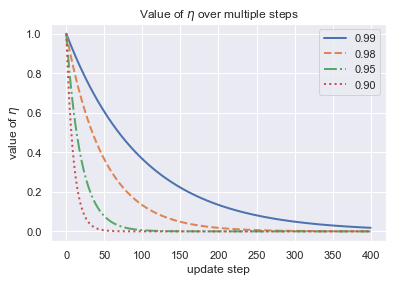

In [21]:
# Show different decay schedules for the learning rate

x = np.linspace(0, 400, 401)
y99 = .99 ** x
y98 = .98 ** x
y95 = .95 ** x
y90 = .90 ** x
plt.plot(x, y99, label='0.99', lw=2, linestyle='-')
plt.plot(x, y98, label='0.98', lw=2, linestyle='--')
plt.plot(x, y95, label='0.95', lw=2, linestyle='-.')
plt.plot(x, y90, label='0.90', lw=2, linestyle=':')
plt.legend(loc='upper right')
plt.xlabel('update step')
plt.ylabel('value of $\eta$')
plt.title('Value of $\eta$ over multiple steps')
file_helper.save_figure('exponential-decay')
plt.show()

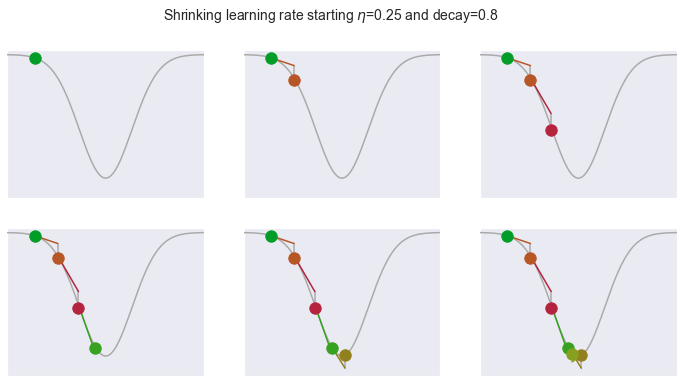

In [22]:
# Show descent into the bowl with learning rate decay

(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
start_eta=0.25
eta_falloff=0.8
for y in range(2):
    for x in range(3):
        plt.subplot(2, 3, 1+x+(y*3))
        plot_learning(xs, ys, ds, -0.73, num_pts=1+x+(y*3), start_eta=start_eta, eta_falloff=eta_falloff)
        plt.ylim(-1.6, 10.4)
plt.suptitle("Shrinking learning rate starting $\eta$="+str(start_eta)+" and decay="+str(eta_falloff), fontsize=14)
file_helper.save_figure("shrinking-learning-rate-grid")
plt.show()

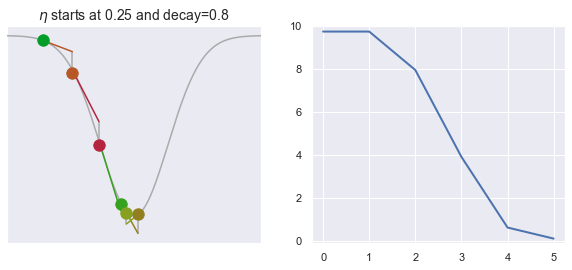

In [23]:
# Show descent into the bowl with learning rate decay

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
start_eta=0.25
eta_falloff=0.8
errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=start_eta, eta_falloff=eta_falloff)
plt.title("$\eta$ starts at "+str(start_eta)+" and decay="+str(eta_falloff), fontsize=14)
#save_figure("shrinking-learning-rate")

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-6-steps")
plt.show()

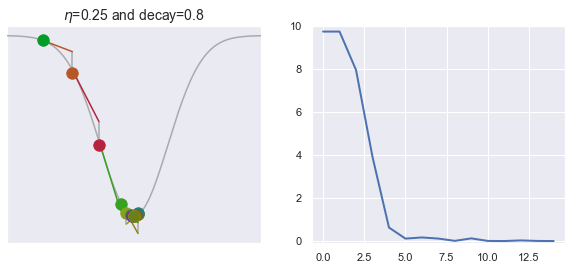

In [24]:
# Show descent into the bowl with learning rate decay and more steps

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
start_eta=0.25
eta_falloff=0.8
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=start_eta, eta_falloff=eta_falloff)
plt.title("$\eta$="+str(start_eta)+" and decay="+str(eta_falloff), fontsize=14)
#save_figure("shrinking-learning-rate-15-steps")

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-15-steps")
plt.show()

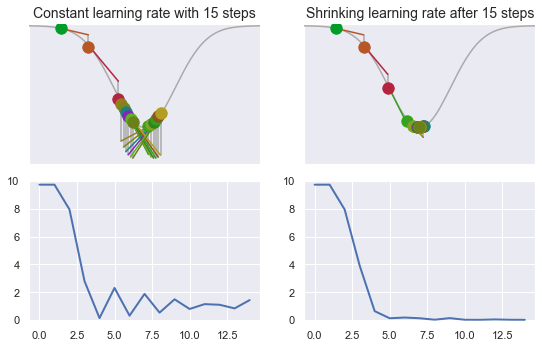

In [25]:
# Compare constant and decaying learning rates

(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(8,5))
plt.subplot(2, 2, 1)
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=0.25, eta_falloff=1)
plt.title("Constant learning rate with 15 steps", fontsize=14)
plt.ylim(-3.6, 10.2)
plt.subplot(2, 2, 3)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
plt.subplot(2, 2, 2)
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=0.25, eta_falloff=0.8)
plt.title("Shrinking learning rate after 15 steps", fontsize=14)
plt.ylim(-3.6, 10.2)
plt.subplot(2, 2, 4)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
plt.tight_layout()
file_helper.save_figure("constant-and-shrinking-learning-rate-15-steps")
plt.show()

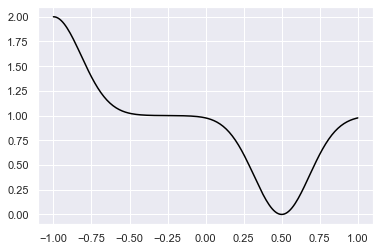

In [26]:
# Show the data with the plateau

(xs, ys, ds) = make_up_plateau_down()
plt.plot(xs, ys, color='black')
plt.ylim(-0.1, 2.1)
file_helper.save_figure("momentum-demo-curve")
plt.show()

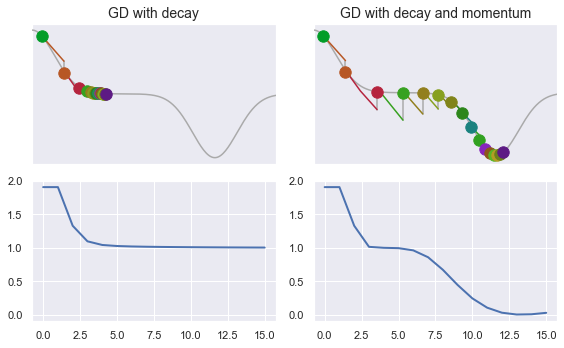

In [27]:
# Show gradient descent with decayed learning rate, and with momentum

(xs, ys, ds) = make_up_plateau_down()
plt.figure(figsize=(8,5))
plt.subplot(2, 2, 1)
errors = plot_learning(xs, ys, ds, -0.93, num_pts=16, start_eta=0.2, eta_falloff=.6)
plt.title("GD with decay", fontsize=14)
plt.subplot(2, 2, 3)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 2)
plt.subplot(2, 2, 2)
errors = plot_learning(xs, ys, ds, -0.93, num_pts=16, start_eta=0.2, eta_falloff=.6, momentum=True, gamma=0.75)
plt.title("GD with decay and momentum", fontsize=14)
plt.subplot(2, 2, 4)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 2)
plt.tight_layout()
file_helper.save_figure("gd-plateau-with-momentum")
plt.show()

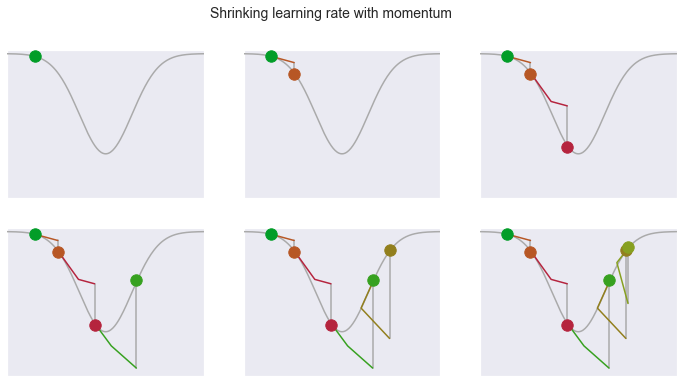

In [28]:
# Show some steps with momentum

(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
for y in range(2):
    for x in range(3):
        plt.subplot(2, 3, 1+x+(y*3))
        plot_learning(xs, ys, ds, -0.73, num_pts=1+x+(y*3), start_eta=0.25, eta_falloff=.8, 
                      momentum=True, gamma=0.7)
        plt.ylim(-4.4, 10.4)
plt.suptitle("Shrinking learning rate with momentum", fontsize=14)
file_helper.save_figure("shrinking-learning-rate-with-momentum-grid")
plt.show()

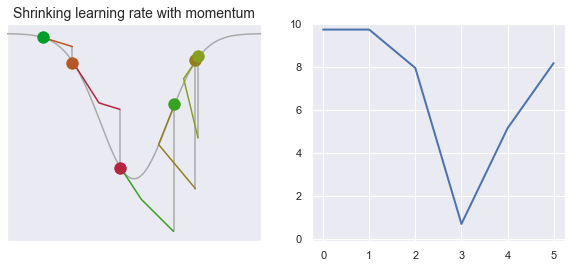

In [29]:
# Show a decaying learning rate with momentum

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=0.25, eta_falloff=0.8, 
                      momentum=True, gamma=0.7)
plt.title("Shrinking learning rate with momentum", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-with-momentum")
plt.show()

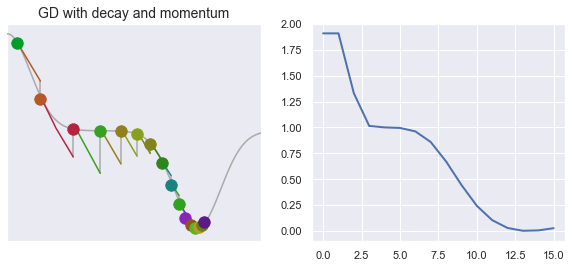

In [30]:
# gradient descent with both learning rate decay and momentum

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_up_plateau_down()
errors = plot_learning(xs, ys, ds, -0.93, num_pts=16, start_eta=0.2, eta_falloff=.6, momentum=True, gamma=0.75)
plt.title("GD with decay and momentum", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 2)
file_helper.save_figure("gd-plateau-with-momentum-only")
plt.show()

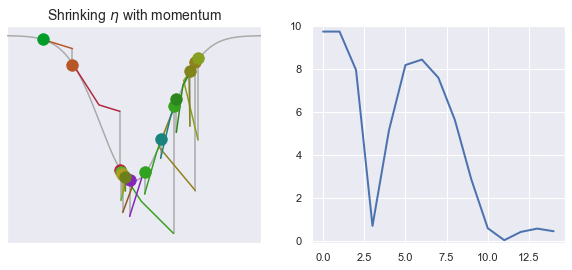

In [31]:
# gradient descent with both learning rate decay and momentum on the bowl

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=0.25, eta_falloff=0.8, 
                      momentum=True, gamma=0.7)
plt.title("Shrinking $\eta$ with momentum", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-with-momentum-15-pts")
plt.show()

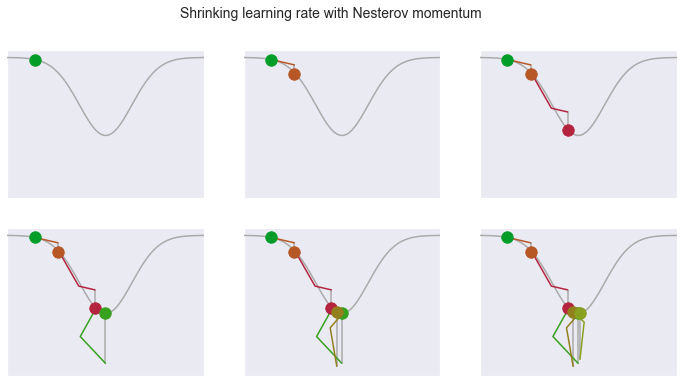

In [32]:
# Show decaying learning rate along with Nesterov momentum

(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
for y in range(2):
    for x in range(3):
        plt.subplot(2, 3, 1+x+(y*3))
        plot_learning(xs, ys, ds, -0.73, num_pts=1+x+(y*3), start_eta=0.25, eta_falloff=.8, 
                      momentum=True, gamma=0.7, nesterov=True)
        plt.ylim(-8, 11)
plt.suptitle("Shrinking learning rate with Nesterov momentum", fontsize=14)
file_helper.save_figure("shrinking-learning-rate-with-nesterov-momentum-grid")
plt.show()

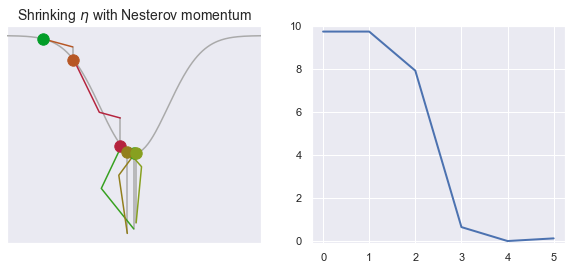

In [33]:
# Show decaying learning rate along with Nesterov momentum

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=0.25, eta_falloff=0.8, 
                      momentum=True, gamma=0.7, nesterov=True)
plt.title("Shrinking $\eta$ with Nesterov momentum", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-with-nesterov-momentum")
plt.show()

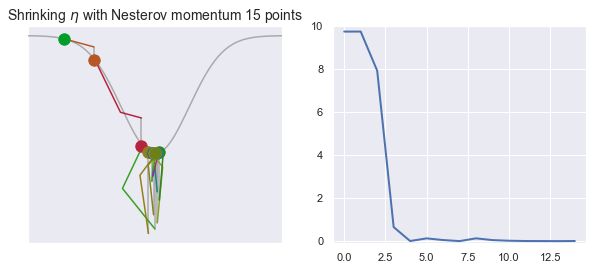

In [34]:
# Show decaying learning rate along with Nesterov momentum for more steps

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=0.25, eta_falloff=0.8, 
                      momentum=True, gamma=0.7, nesterov=True)
plt.title("Shrinking $\eta$ with Nesterov momentum 15 points", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-with-nesterov-momentum-15-pts")
plt.show()